# Loading the Data

In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_error
import shap
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, auc
import cfbd
from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('t_ds', 'tds'))
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


In [5]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [6]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [7]:
game_team_stats_dir = join(DATA_DIR, 'game_team_stats')
if not os.path.exists(game_team_stats_dir):
    os.makedirs(game_team_stats_dir)

def flatten_team_data(row):
    game_id = row['id']
    teams_data = row['teams']
    
    # Parse the JSON string if it's not already parsed
    if isinstance(teams_data, str):
        teams_data = json.loads(teams_data)
    
    rows = []
    for team in teams_data:
        # Create base dictionary with non-stats fields
        team_row = {
            'game_id': game_id,
            'teamId': team['teamId'],
            'team': team['team'],
            'conference': team['conference'],
            'homeAway': team['homeAway'],
            'points': team['points']
        }
        
        # Add stats fields
        for stat in team['stats']:
            # Convert stat names to valid column names if needed
            col_name = stat['category']
            team_row[col_name] = stat['stat']
        
        rows.append(team_row)
    
    return rows

all_dfs = []
for year in YEARS:
    file_path = join(DATA_DIR, 'game_team_stats', f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
        all_dfs.append(tmp)
    else:
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} team stats data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.GamesApi(api_client)
                data = api_instance.get_game_team_stats(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                games_count = games.query('season == @year and week == @week and home_division == "fbs"').shape[0] + \
                    games.query('season == @year and week == @week and away_division == "fbs"').shape[0]
                print(f'No team stats data for {year} week {week}, number of FBS teams: {games_count}')
                continue

            flattened_data = []
            for _, row in tmp.iterrows():
                flattened_data.extend(flatten_team_data(row))
            result_df = pd.DataFrame(flattened_data)

            base_columns = ['game_id', 'teamId', 'team', 'conference', 'homeAway', 'points']
            stat_columns = [col for col in result_df.columns if col not in base_columns]
            result_df = result_df[base_columns + stat_columns]
            result_df.columns = convert_to_snake_case(result_df.columns)
            season_dfs.append(result_df)

        season_df = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)

        all_dfs.append(season_df)
        season_df.to_parquet(file_path)

team_stats = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
team_stats.head()

Reading ../data/game_team_stats/2013.parquet from cached data
Reading ../data/game_team_stats/2014.parquet from cached data
Reading ../data/game_team_stats/2015.parquet from cached data
Reading ../data/game_team_stats/2016.parquet from cached data
Reading ../data/game_team_stats/2017.parquet from cached data
Reading ../data/game_team_stats/2018.parquet from cached data
Reading ../data/game_team_stats/2019.parquet from cached data
Reading ../data/game_team_stats/2020.parquet from cached data
Reading ../data/game_team_stats/2021.parquet from cached data
Reading ../data/game_team_stats/2022.parquet from cached data
Reading ../data/game_team_stats/2023.parquet from cached data
Reading ../data/game_team_stats/2024.parquet from cached data


,game_id,team_id,team,conference,home_away,points,possession_time,interceptions,fumbles_lost,turnovers,total_penalties_yards,yards_per_rush_attempt,rushing_attempts,rushing_yards,yards_per_pass,completion_attempts,net_passing_yards,total_yards,fourth_down_eff,third_down_eff,first_downs,kicking_points,kick_returns,kick_return_tds,kick_return_yards,passing_tds,rushing_tds,fumbles_recovered,passes_intercepted,interception_tds,interception_yards,punt_returns,punt_return_tds,punt_return_yards,passes_deflected,qb_hurries,sacks,tackles,defensive_tds,tackles_for_loss,total_fumbles
0,333642426,2393,Middle Tennessee,Conference USA,away,6,23:04,2,0,2,6-74,3.4,27,91,6.6,19-33,218,309,0-1,2-8,21,6,5,0,94,0,0,2,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,333642426,2426,Navy,FBS Independents,home,24,36:56,0,2,2,2-18,5.5,67,366,2.7,3-7,19,385,2-2,8-14,26,6,3,0,98,0,3,0,2,0,41,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,332430120,2229,Florida International,Conference USA,away,10,25:29,1,1,2,3-24,2.3,40,91,3.6,10-22,80,171,1-3,4-17,9,4,6,0,110,0,1,2,None,None,None,2,0,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,332430120,120,Maryland,ACC,home,43,39:53,0,2,2,2-10,6.0,42,251,11.2,25-29,325,576,0-1,4-13,26,13,3,0,70,3,2,1,1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,333610120,276,Marshall,Conference USA,away,31,26:38,0,0,0,6-55,3.9,35,138,7.7,28-44,337,475,1-1,6-15,24,7,5,0,124,3,1,0,1,0,5,3,0,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
team_stats.head()

,game_id,team_id,team,conference,home_away,points,possession_time,interceptions,fumbles_lost,turnovers,total_penalties_yards,yards_per_rush_attempt,rushing_attempts,rushing_yards,yards_per_pass,completion_attempts,net_passing_yards,total_yards,fourth_down_eff,third_down_eff,first_downs,kicking_points,kick_returns,kick_return_tds,kick_return_yards,passing_tds,rushing_tds,fumbles_recovered,passes_intercepted,interception_tds,interception_yards,punt_returns,punt_return_tds,punt_return_yards,passes_deflected,qb_hurries,sacks,tackles,defensive_tds,tackles_for_loss,total_fumbles
0,333642426,2393,Middle Tennessee,Conference USA,away,6,23:04,2,0,2,6-74,3.4,27,91,6.6,19-33,218,309,0-1,2-8,21,6,5,0,94,0,0,2,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,333642426,2426,Navy,FBS Independents,home,24,36:56,0,2,2,2-18,5.5,67,366,2.7,3-7,19,385,2-2,8-14,26,6,3,0,98,0,3,0,2,0,41,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,332430120,2229,Florida International,Conference USA,away,10,25:29,1,1,2,3-24,2.3,40,91,3.6,10-22,80,171,1-3,4-17,9,4,6,0,110,0,1,2,None,None,None,2,0,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,332430120,120,Maryland,ACC,home,43,39:53,0,2,2,2-10,6.0,42,251,11.2,25-29,325,576,0-1,4-13,26,13,3,0,70,3,2,1,1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,333610120,276,Marshall,Conference USA,away,31,26:38,0,0,0,6-55,3.9,35,138,7.7,28-44,337,475,1-1,6-15,24,7,5,0,124,3,1,0,1,0,5,3,0,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Research on if penalty totals are attributed to team discipline -> past penalty counts predict future penalty counts

In [9]:
team_stat_cols = [
    'game_id', 
    'team_id', 
    'team', 
    'home_away', 
    'total_penalties_yards',
    'rushing_attempts',
    'completion_attempts',
    'kick_returns',
    'punt_returns',
    'kick_return_tds',
    'passing_tds',
    'rushing_tds',
    'punt_return_tds',
    'defensive_tds'
]

field_goal_attempts = (
    plays
    .query('play_type.str.lower().str.contains("field goal")')
    .groupby(['game_id', 'offense'])
    .agg({'play_type': 'count'})
    .rename(columns={'play_type': 'field_goal_attempts'})
    .reset_index()
)

penalties = (
    games[['id','season','week']]  #,'home_team','home_division','away_team','away_division']]
    .rename(columns={'id': 'game_id'})
    .merge(
        team_stats[team_stat_cols],
        on=['game_id'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team_id', 'division', 'elo']],
        left_on=['season', 'week', 'team_id'],
        right_on=['season', 'week', 'team_id'],
        how='left'
    )
    .dropna(subset=['total_penalties_yards','completion_attempts'], ignore_index=True)
    .assign(
        penalty_count=lambda x: np.where(
            x.total_penalties_yards.str.split('-').str.len() == 2,
            x.total_penalties_yards.str.split('-').str[0],
            np.nan
        ),
        penalty_yards=lambda x: np.where(
            x.total_penalties_yards.str.split('-').str.len() == 2,
            x.total_penalties_yards.str.split('-').str[1],
            np.nan
        ),
        pass_attempts=lambda x: np.where(
            x.completion_attempts.str.split('-').str.len() == 2,
            x.completion_attempts.str.split('-').str[1],
            np.nan
        )
    )
    .dropna(subset=['penalty_count','penalty_yards','completion_attempts'], ignore_index=True)
    .drop(columns=['total_penalties_yards'])
    .assign(
        penalty_count=lambda x: x.penalty_count.astype(int),
        penalty_yards=lambda x: x.penalty_yards.astype(int),
        pass_attempts=lambda x: x.pass_attempts.astype(int),
        rush_attempts=lambda x: x.rushing_attempts.fillna(0).astype(int),
        kick_returns=lambda x: x.kick_returns.fillna(0).astype(int),
        punt_returns=lambda x: x.punt_returns.fillna(0).astype(int),
        kick_return_tds=lambda x: x.kick_return_tds.fillna(0).astype(int),
        passing_tds=lambda x: x.passing_tds.fillna(0).astype(int),
        rushing_tds=lambda x: x.rushing_tds.fillna(0).astype(int),
        punt_return_tds=lambda x: x.punt_return_tds.fillna(0).astype(int),
        defensive_tds=lambda x: x.defensive_tds.fillna(0).astype(int)
    )
    .assign(
        xp_or_2pt_attempts=lambda x: 
            x.passing_tds.astype(int) +
            x.rushing_tds.astype(int) +
            x.kick_return_tds.astype(int) +
            x.punt_return_tds.astype(int) +
            x.defensive_tds.astype(int),
    )
    .drop(columns=[
        'rushing_attempts', 'completion_attempts', 'kick_return_tds', 
        'passing_tds', 'rushing_tds',
        'punt_return_tds', 'defensive_tds',
    ])
    .merge(
        field_goal_attempts.rename(columns={'offense': 'team'}),
        on=['game_id', 'team'],
        how='left'
    )
)

penalties.head()

,game_id,season,week,team_id,team,home_away,kick_returns,punt_returns,division,elo,penalty_count,penalty_yards,pass_attempts,rush_attempts,xp_or_2pt_attempts,field_goal_attempts
0,332412309,2013,1,2335.0,Liberty,away,2,0,fcs,1553.191164,4,30,22,22,1,1.0
1,332412309,2013,1,2309.0,Kent State,home,1,4,fbs,1954.443118,9,79,28,49,2,1.0
2,332412579,2013,1,153.0,North Carolina,away,4,2,fbs,2475.527442,6,55,43,36,1,1.0
3,332412579,2013,1,2579.0,South Carolina,home,2,3,fbs,3035.188373,7,53,21,38,3,2.0
4,332410154,2013,1,154.0,Wake Forest,home,2,3,fbs,1961.923659,4,35,26,54,3,3.0


In [10]:
game_counts = penalties.groupby(['season', 'team_id']).size().reset_index(name='game_count')
teams_with_12_plus_games = game_counts[game_counts['game_count'] >= 12][['season', 'team_id']]
df_12_plus = pd.merge(penalties, teams_with_12_plus_games, on=['season', 'team_id'], how='inner')
df_12_plus.sort_values(['season', 'team_id', 'week'], inplace=True)

def split_first_next(g):
    g = g.sort_values('week')
    first_6 = g.head(6)
    next_6 = g.iloc[6:12]  # Games 7-12
    return pd.Series({
        'first_6_penalty_count_mean': first_6['penalty_count'].mean(),
        'first_6_penalty_count_median': first_6['penalty_count'].median(),
        'first_6_penalty_count': first_6['penalty_count'].sum(),
        'first_6_penalty_yards_mean': first_6['penalty_yards'].mean(),
        'first_6_penalty_yards_median': first_6['penalty_yards'].median(),
        'next_6_penalty_count_mean': next_6['penalty_count'].mean(),
        'next_6_penalty_count_median': next_6['penalty_count'].median(),
        'next_6_penalty_count': next_6['penalty_count'].sum(),
        'next_6_penalty_yards_mean': next_6['penalty_yards'].mean(),
        'next_6_penalty_yards_median': next_6['penalty_yards'].median()
    })

results = df_12_plus.groupby(['season', 'team_id', 'team']).apply(split_first_next, include_groups=False).reset_index()

correlations = {
    'penalty_count_mean_r2': results[['first_6_penalty_count_mean', 'next_6_penalty_count_mean']].corr().iloc[0, 1] ** 2,
    'penalty_count_median_r2': results[['first_6_penalty_count_median', 'next_6_penalty_count_median']].corr().iloc[0, 1] ** 2,
    'penalty_count_r2': results[['first_6_penalty_count', 'next_6_penalty_count']].corr().iloc[0, 1] ** 2,
    'penalty_yards_mean_r2': results[['first_6_penalty_yards_mean', 'next_6_penalty_yards_mean']].corr().iloc[0, 1] ** 2,
    'penalty_yards_median_r2': results[['first_6_penalty_yards_median', 'next_6_penalty_yards_median']].corr().iloc[0, 1] ** 2
}
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])

corr_df

,correlation
penalty_count_mean_r2,0.173820
penalty_count_median_r2,0.120956
penalty_count_r2,0.173820
penalty_yards_mean_r2,0.155529
penalty_yards_median_r2,0.114014


In [11]:
results.query('first_6_penalty_count > next_6_penalty_count').shape[0] / results.shape[0]

0.5859872611464968

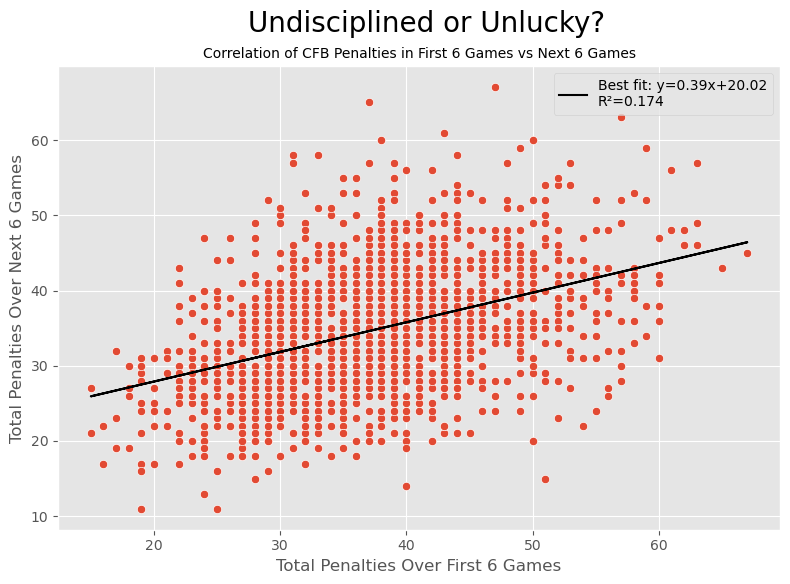

In [12]:
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)

# First plot: Mean Penalty Yards
sns.scatterplot(
    data=results, 
    x='first_6_penalty_count', 
    y='next_6_penalty_count', 
    ax=ax
)

# Calculate regression line and R-squared for mean
x_mean = results['first_6_penalty_count']
y_mean = results['next_6_penalty_count']
slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = stats.linregress(x_mean, y_mean)
r_squared_mean = r_value_mean**2

# Add regression line
ax.plot(x_mean, intercept_mean + slope_mean*x_mean, 'black', 
        label=f'Best fit: y={slope_mean:.2f}x+{intercept_mean:.2f}\nR²={r_squared_mean:.3f}')

fig.suptitle('Undisciplined or Unlucky?', fontsize=20, y=.965, x=.54)
ax.set_title('Correlation of CFB Penalties in First 6 Games vs Next 6 Games', fontsize=10)
ax.set_xlabel('Total Penalties Over First 6 Games')
ax.set_ylabel('Total Penalties Over Next 6 Games')
ax.legend()
plt.tight_layout()
plt.show()

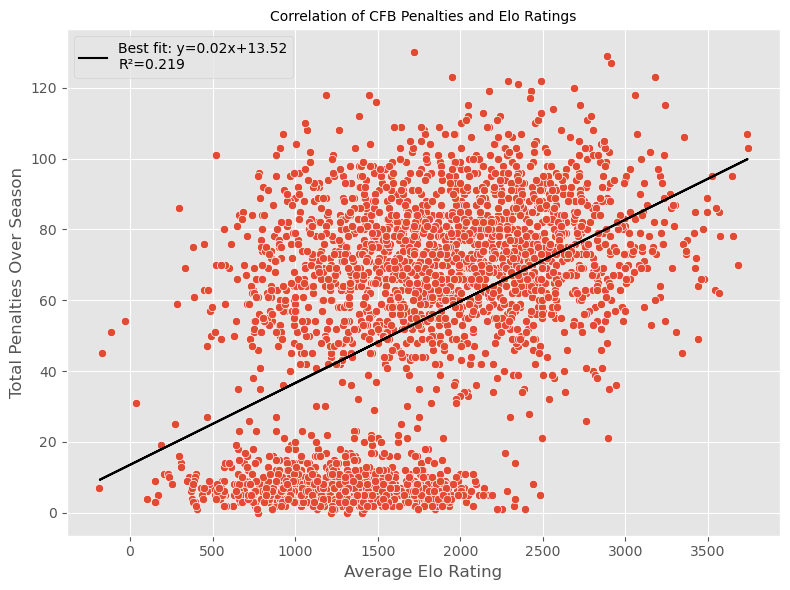

In [13]:
season_penalties = (
    penalties
    .groupby(['season', 'team_id'])
    .agg({'elo':'mean','penalty_count': 'sum', 'penalty_yards': 'sum'})
    .reset_index()
    .rename(columns={
        'penalty_count': 'total_penalty_count', 
        'penalty_yards': 'total_penalty_yards',
        'elo': 'average_elo'
    })
)

plt.style.use('ggplot')

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)

# First plot: Mean Penalty Yards
sns.scatterplot(
    data=season_penalties, 
    x='average_elo', 
    y='total_penalty_count', 
    ax=ax
)

# Calculate regression line and R-squared for mean
x_mean = season_penalties['average_elo']
y_mean = season_penalties['total_penalty_count']
slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = stats.linregress(x_mean, y_mean)
r_squared_mean = r_value_mean**2

# Add regression line
ax.plot(x_mean, intercept_mean + slope_mean*x_mean, 'black', 
        label=f'Best fit: y={slope_mean:.2f}x+{intercept_mean:.2f}\nR²={r_squared_mean:.3f}')
ax.set_title('Correlation of CFB Penalties and Elo Ratings', fontsize=10)
ax.set_xlabel('Average Elo Rating')
ax.set_ylabel('Total Penalties Over Season')
ax.legend()
plt.tight_layout()
plt.show()

# Getting Penalty Base Rate Probabilities

In [31]:
home_cols = ['game_id', 'season', 'week', 'team_id', 'team', 'division',
       'kick_returns', 'punt_returns', 'penalty_count',
       'penalty_yards', 'pass_attempts', 'rush_attempts', 'xp_or_2pt_attempts',
       'field_goal_attempts']
away_cols = ['game_id', 'team_id', 'team', 'division',
       'kick_returns', 'punt_returns', 'penalty_count',
       'penalty_yards', 'pass_attempts', 'rush_attempts', 'xp_or_2pt_attempts',
       'field_goal_attempts']

play_totals = (
    games[['id','home_id','away_id']].rename(columns={'id': 'game_id'})
    .merge(
        penalties[home_cols].rename(columns={
            'team_id': 'home_id',
            'team': 'home_team',
            'division': 'home_division',
            'penalty_yards': 'home_penalty_yards',
            'penalty_count': 'home_penalty_count',
            'kick_returns': 'home_kick_returns',
            'punt_returns': 'home_punt_returns',
            'pass_attempts': 'home_pass_attempts',
            'rush_attempts': 'home_rush_attempts',
            'xp_or_2pt_attempts': 'home_xp_or_2pt_attempts',
            'field_goal_attempts': 'home_field_goal_attempts'        
        }),
        on=['game_id', 'home_id'],
        how='left'
    ).drop(columns=['home_id'])
    .merge(
        penalties[away_cols].rename(columns={
            'team_id': 'away_id',
            'team': 'away_team',
            'division': 'away_division',
            'penalty_yards': 'away_penalty_yards',
            'penalty_count': 'away_penalty_count',
            'kick_returns': 'away_kick_returns',
            'punt_returns': 'away_punt_returns',
            'pass_attempts': 'away_pass_attempts',
            'rush_attempts': 'away_rush_attempts',
            'xp_or_2pt_attempts': 'away_xp_or_2pt_attempts',
            'field_goal_attempts': 'away_field_goal_attempts'        
        }),
        on=['game_id', 'away_id'], 
        how='left'
    ).drop(columns=['away_id'])
    .assign(
        total_plays=lambda x: ( 
            x.home_pass_attempts.fillna(0).astype(int) +
            x.home_rush_attempts.fillna(0).astype(int) +
            x.home_kick_returns.fillna(0).astype(int) +
            x.home_punt_returns.fillna(0).astype(int) +
            x.home_xp_or_2pt_attempts.fillna(0).astype(int) +
            x.home_field_goal_attempts.fillna(0).astype(int) +
            x.home_penalty_count.fillna(0).astype(int) +
            x.away_pass_attempts.fillna(0).astype(int) +
            x.away_rush_attempts.fillna(0).astype(int) +
            x.away_kick_returns.fillna(0).astype(int) +
            x.away_punt_returns.fillna(0).astype(int) +
            x.away_xp_or_2pt_attempts.fillna(0).astype(int) +
            x.away_field_goal_attempts.fillna(0).astype(int) +
            x.away_penalty_count.fillna(0).astype(int)
        ).astype(int)
    )
    .query('total_plays > 120')
)

play_totals.head()

,game_id,season,week,home_team,home_division,home_kick_returns,home_punt_returns,home_penalty_count,home_penalty_yards,home_pass_attempts,home_rush_attempts,home_xp_or_2pt_attempts,home_field_goal_attempts,away_team,away_division,away_kick_returns,away_punt_returns,away_penalty_count,away_penalty_yards,away_pass_attempts,away_rush_attempts,away_xp_or_2pt_attempts,away_field_goal_attempts,total_plays
0,332412309,2013.0,1.0,Kent State,fbs,1.0,4.0,9.0,79.0,28.0,49.0,2.0,1.0,Liberty,fcs,2.0,0.0,4.0,30.0,22.0,22.0,1.0,1.0,146
1,332412579,2013.0,1.0,South Carolina,fbs,2.0,3.0,7.0,53.0,21.0,38.0,3.0,2.0,North Carolina,fbs,4.0,2.0,6.0,55.0,43.0,36.0,1.0,1.0,169
2,332410154,2013.0,1.0,Wake Forest,fbs,2.0,3.0,4.0,35.0,26.0,54.0,3.0,3.0,Presbyterian,fcs,5.0,0.0,6.0,43.0,19.0,24.0,1.0,NaN,150
4,332412050,2013.0,1.0,Ball State,fbs,5.0,1.0,5.0,40.0,40.0,32.0,7.0,2.0,Illinois State,fcs,5.0,0.0,6.0,40.0,29.0,36.0,4.0,NaN,172
5,332410084,2013.0,1.0,Indiana,fbs,3.0,4.0,6.0,66.0,30.0,54.0,10.0,1.0,Indiana State,fcs,5.0,2.0,7.0,83.0,32.0,39.0,3.0,NaN,196


In [32]:
play_totals.total_plays.describe()

count    12311.000000
mean       167.434327
std         17.833581
min        121.000000
25%        155.000000
50%        166.000000
75%        178.500000
max        258.000000
Name: total_plays, dtype: float64

In [33]:
penalties.penalty_count.describe()

count    24723.000000
mean         5.987906
std          2.835179
min          0.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         23.000000
Name: penalty_count, dtype: float64

In [34]:
penalties.penalty_yards.describe()

count    24723.000000
mean        52.795777
std         27.381979
min          0.000000
25%         34.000000
50%         50.000000
75%         70.000000
max        224.000000
Name: penalty_yards, dtype: float64

In [ ]:
penaltys_per_play = penalties.penalty_count.median() / play_totals.total_plays.median()
print(f'Median penalties per play: {penaltys_per_play * 100:.2f}%')

Median penalties per play: 3.61%


In [46]:
median_penalty_yards = penalties.penalty_yards.median() / penalties.penalty_count.median()
print(f'Median penalty yards per penalty: {median_penalty_yards:.2f} yards per penalty')

Median penalty yards per penalty: 8.33 yards per penalty


### Simulated Penalty Yardage Distribution

To simulate penalty yardage realistically in college football, we use a weighted mix of common penalty yard distances:

- **5-yard penalties** (e.g., false start, offsides): **49%**
- **10-yard penalties** (e.g., holding, illegal block): **36%**
- **15-yard penalties** (e.g., personal foul, facemask): **15%**

We compute the expected yards lost per penalty as:

$
\text{Expected Penalty Yards} = 5 \times 0.49 + 10 \times 0.36 + 15 \times 0.15 = 2.45 + 3.6 + 2.25 = \mathbf{8.3 \text{ yards}}
$

This closely matches the observed average penalty yardage of **~8.33 yards per penalty**, and forms a realistic pseudo-distribution for simulation. This distribution will be sampled at a rate of **3.6% per team per play**, aligning with the median penalty per play rate.
